In [31]:
# Prophet model with additional regressor the working_hours of each store
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
sns.set_style('whitegrid')


In [88]:

# Load your preprocessed dataset
data = pd.read_parquet('data/n_forecast_preprocessed.parquet', engine='pyarrow', dtype_backend='numpy_nullable')


# Convert the 'sales_date' column to a datetime type
data['sales_date'] = pd.to_datetime(data['sales_date'])


In [33]:
store_names = data['store_hashed'].unique()

In [34]:
store_names[0:10]


<StringArray>
['b9d487a30398d42ecff55c228ed5652b', 'c3e0c62ee91db8dc7382bde7419bb573',
 '90db9da4fc5414ab55a9fe495d555c06', '07042ac7d03d3b9911a00da43ce0079a',
 'b60c5ab647a27045b462934977ccad9a', '90e1357833654983612fb05e3ec9148c',
 'f5c3dd7514bf620a1b85450d2ae374b1', '4496bf24afe7fab6f046bf4923da8de6',
 '57c0531e13f40b91b3b0f1a30b529a1d', 'a09e75c5c86a7bf6582d2b4d75aad615']
Length: 10, dtype: string

In [35]:
# forecast for one store
# select the store
store = 'a09e75c5c86a7bf6582d2b4d75aad615'

# select the data for the store
data_store = data[data['store_hashed'] == store]

# select the columns for the prophet model
data_store = data_store[['sales_date', 'n_transactions']] ##, 'working_hours']]
# rename the columns for the prophet model
data_store.columns = ['ds', 'y'] ##, 'working_hours']



In [36]:
data_store.isna().sum()

ds    0
y     0
dtype: int64

In [40]:
# Forecast for one store
# Create the prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add the working_hours as regressor
# model.add_regressor('working_hours', mode='additive')

In [41]:
model.fit(data_store)

12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
model.params

OrderedDict([('lp__', array([[2972.55]])),
             ('k', array([[0.0585355]])),
             ('m', array([[0.619104]])),
             ('delta',
              array([[-4.50171e-09, -1.39789e-07, -3.37671e-03, -2.42044e-02,
                      -2.97056e-02, -5.23871e-02, -3.10972e-02, -2.22911e-04,
                       2.39923e-08,  1.76810e-07,  4.29602e-02,  4.75421e-02,
                       1.97750e-08,  5.21016e-08,  1.27976e-07, -1.05996e-08,
                      -2.82774e-08, -1.41168e-07,  9.31682e-10,  5.26770e-08,
                       5.67117e-07,  1.54580e-02,  2.86380e-02,  1.93582e-02,
                       3.64970e-08]])),
             ('sigma_obs', array([[0.0531176]])),
             ('beta',
              array([[-0.00139266, -0.00455712, -0.0209586 ,  0.0110537 ,  0.00526628,
                       0.0103118 , -0.0182225 ,  0.00664661,  0.00209072,  0.00231356,
                      -0.00524688,  0.0224762 , -0.00950058,  0.00488579, -0.00059333,
          

In [43]:
future_dates = model.make_future_dataframe(periods=50, freq='D')

In [44]:
# Initialize metrics storage
mape_scores = {}
rmse_scores = {}

In [45]:
forecast_data = pd.DataFrame(columns=['store_hashed', 'ds', 'yhat', 'yhat_lower', 'yhat_upper'])

In [46]:
future = model.predict(future_dates)

In [47]:
forecast_data = pd.concat([forecast_data, future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]], axis=0)

In [48]:
actual = data_store.set_index('ds')['y']
predicted = future.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]

mape = np.mean(np.abs(predicted['yhat'] - actual)/np.abs(actual))
mape_scores[store] = mape

rmse = np.mean((predicted['yhat'] - actual)**2)**.5
rmse_scores[store] = rmse


In [49]:
mape_scores

{'a09e75c5c86a7bf6582d2b4d75aad615': 0.05780269942088937}

In [50]:
rmse_scores

{'a09e75c5c86a7bf6582d2b4d75aad615': 283.02815278808805}

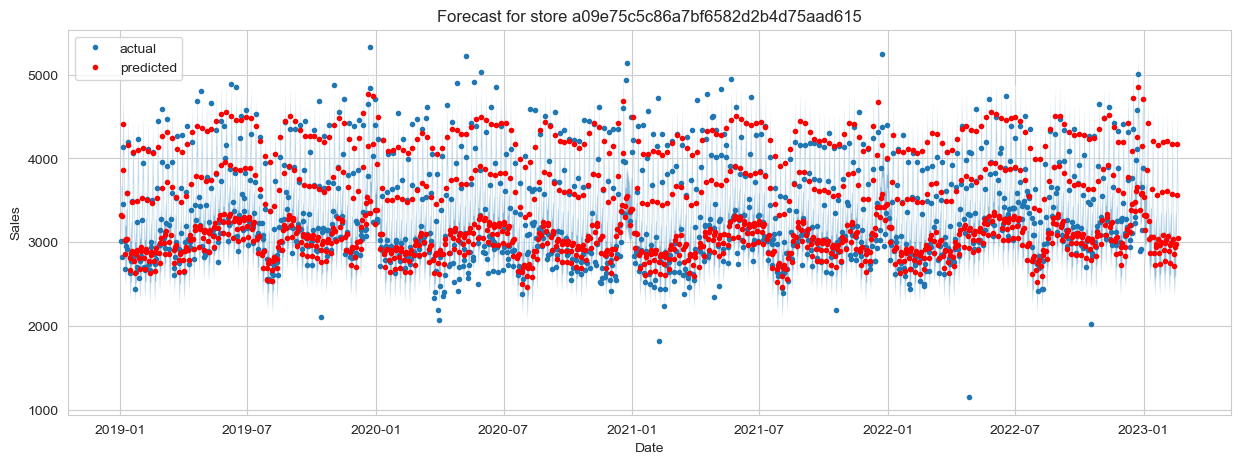

In [51]:
# Plot the forecast
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(actual.index, actual, label='actual', marker='.', linestyle='None') 
ax.plot(predicted.index, predicted['yhat'], label='predicted',  marker='.', linestyle='None', color='red')
ax.fill_between(predicted.index, predicted['yhat_lower'], predicted['yhat_upper'], alpha=0.5)
ax.set_title(f'Forecast for store {store}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend(loc='upper left')
plt.show()


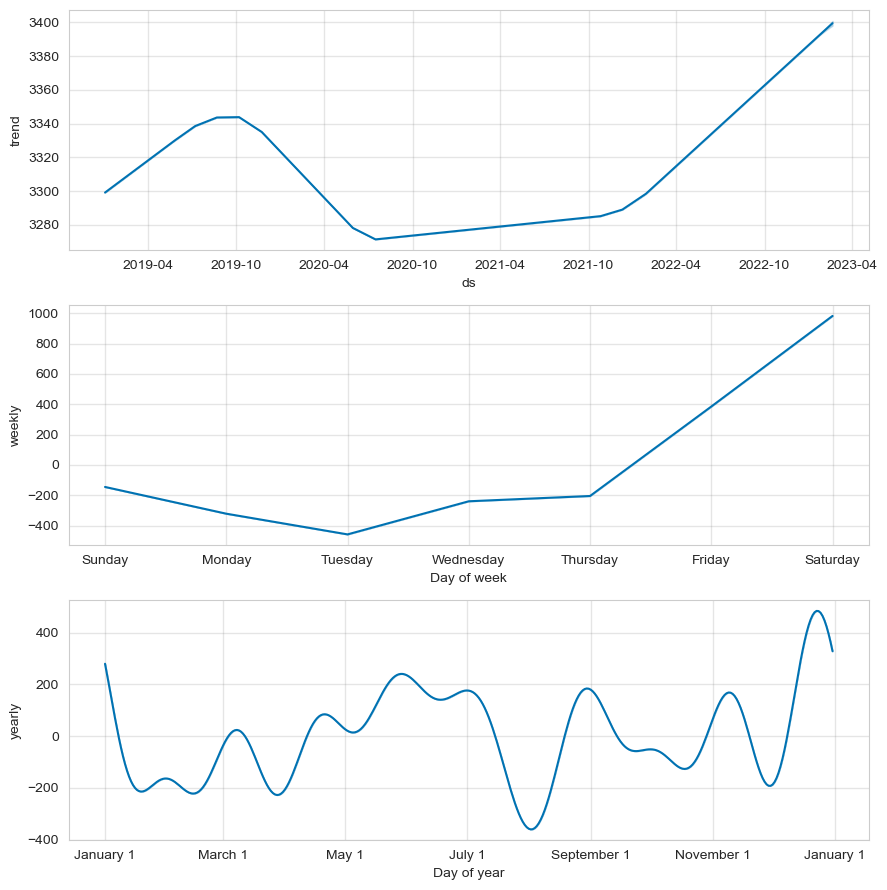

In [52]:
# plot model components
model.plot_components(future)
plt.show()

# With additional Regressor working_hours

In [90]:
# forecast for one store
# select the store
store = 'a09e75c5c86a7bf6582d2b4d75aad615'

# select the data for the store
data_store2 = data[data['store_hashed'] == store]

# select the columns for the prophet model
data_store2 = data_store2[['sales_date', 'n_transactions', 'working_hours']]
# rename the columns for the prophet model
data_store2.columns = ['ds', 'y', 'working_hours']

# data_store2['working_hours'] = data_store2['working_hours'].astype(float)

In [106]:
# Create a separate DataFrame for 'working_hours'
working_hours_df = data_store2[['ds', 'working_hours']]


# # Rename the columns for the working_hours DataFrame
working_hours_df.columns = ['ds', 'y']

In [107]:
# Repeat with additional regressor the working_hours    
# Create the prophet model

model2 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add the working_hours as regressor
model2.add_regressor('working_hours')

In [111]:
# fit the model
model2.fit(data_store2)

Exception: Prophet object can only be fit once. Instantiate a new object.

In [112]:
# future dates
future_dates2 = model2.make_future_dataframe(periods=50, freq='D')

In [113]:
mape_scores = {}
rmse_scores = {}

forecast_data = pd.DataFrame(columns=['store_hashed', 'ds', 'yhat', 'yhat_lower', 'yhat_upper'])

In [114]:
future2 = model2.predict(future_dates2)

ValueError: Regressor 'working_hours' missing from dataframe

In [70]:
forecast_data = pd.concat([forecast_data, future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]], axis=0)